In [1]:
from interferometer import Interferometer
from scipy.interpolate import interp1d
import numpy as np
import jax.numpy as jnp
import gw
from matplotlib import pyplot as pl
import corner
import pickle
import jax
%matplotlib inline

from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# simulate data
        #T = 1 # duration of analysis segment
        #srate = 20
        #df = 1/T
        #freqs = jnp.arange(1+srate*T, dtype=jnp.float32)*df
        #f0 = 100
        #Nbins = 1
        #i0 =int(f0/df)
        #self.freqs = jnp.atleast_2d(freqs[i0])


f_min = 0. #minimum frequency cut-off
T = 1.  #data segment duration (8 seconds)
Fs = 20. #samplingfrequency  (Hz)
#t_start = 1126259446. #strain data segment start time 
t_start=0.
# since signals are generated in frequency domain this time is only used for calculating time dealys and hence is set to t_coalsecence

#initialise the detectors
H1 = Interferometer('H1','O3',f_min,T,Fs,t_start,20011997)
L1 = Interferometer('L1','O3',f_min,T,Fs,t_start,27071994)

detectors = [H1, L1]

In [3]:
t=H1.times #time array for the time domain signal
A=0.5
t0=0.5
f0=4.
tau=2./f0
ra=0.5
dec=0.5
psi=0.5


In [4]:
def simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, times, fmin, df):   #without phase for now
    
    t = times
    
    hpt = A * jnp.exp(-(t-t0)**2/tau**2)*jnp.cos(2*jnp.pi*f0*t) #time domain plus polarisation
    hct = A * jnp.exp(-(t-t0)**2/tau**2)*jnp.sin(2*jnp.pi*f0*t) #time domain cross polarisation

    hp = jnp.fft.rfft(hpt) #frequency domain plus polarisation
    hc = jnp.fft.rfft(hct) #frequency domain cross polarisation

    #recreate frequency array
    freqs= df * jnp.arange(len(hp)) 
    #start = int(fmin/df) #index of the first non-zero value of the fd signal (corresponding to f_min)
                          
    #return hp[start:], hc[start:], freqs[start:]
    return hp, hc, freqs
    #return hp, hc

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[-0.05382236+0.00000000e+00j -0.06403203-4.24371755e-16j
 -0.11397019+1.22454135e-16j -0.71667412-1.13206320e-15j
  3.7208638 -7.52286060e-17j -0.7144998 +1.11022302e-16j
 -0.10907061+4.08295513e-16j -0.05496122-8.22432356e-17j
 -0.03710136-4.55521042e-16j -0.03013423-6.85851270e-16j
 -0.02822373+0.00000000e+00j] [-1.11022302e-15+0.j         -2.08940200e-16+0.0270013j
  1.46490155e-16+0.08574646j  1.36773548e-15+0.69343638j
 -2.64451351e-16-3.74124416j -5.55111512e-16+0.6956107j
 -1.53429048e-16+0.09064604j -8.24954992e-16+0.03607211j
 -7.41688265e-16+0.016721j    1.56741664e-15+0.0068965j
  4.44089210e-16+0.j        ]


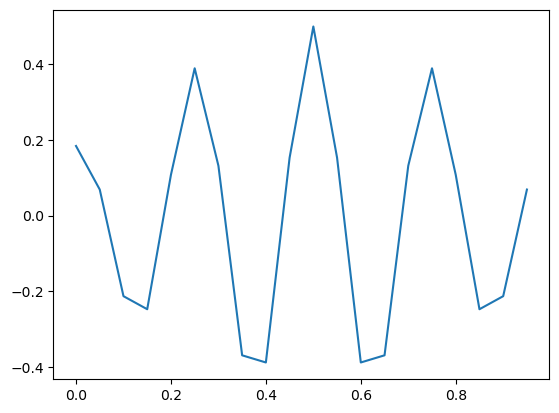

In [5]:
#simulate signal 
hp, hc, freqs = simulate_fd_sine_gaussian_waveform(A,t0,f0,tau,t,0.,H1.df)
hpt = jnp.fft.irfft(hp)
pl.plot(t,hpt)
print(hp,hc)

In [6]:
#something is fucked

def model(theta, detectors):
    
    #create an array to hold the frequency series of the data 
    
    ffreqs = detectors[0].get_frequency_array()     #get frequency array in the detector (should be same for both)
    times = detectors[0].times
    N = len(freqs)
    f_min = freqs[0] 
    df = freqs[1]-freqs[0]
    
    signal = np.zeros(N)
    signal = signal + 0j
    
    signals = {det.name: signal for det in detectors}   #dictionary to hold model signals
    
    A, t0, f0, tau, ra, dec, psi = theta
    
    hp, hc, _ = simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, times, f_min, df)

    for det in detectors:

        #apply antenna response of the detector
    
        fp, fc = det.get_antenna_response_jax(ra, dec, psi, t0)
        hf = hp*fp + hc*fc

        signals[det.name] = hf
            
        #apply delay (following bilby interferometer.p, line 316-322)
        dt_geoct = t0 - det.t_start   #geocentic time of arrival - time segment start time   (time delay at geocenter, 0 for t0_true) 
        dt_delay = det.get_time_delay_jax(ra, dec, t0)  #travel time between geocenter & detector
        tau_delay = dt_geoct + dt_delay

        signals[det.name] *= jnp.exp(-2*jnp.pi*1j*freqs*tau_delay)   # cexp = jnp.exp(-1j*2*jnp.pi*freqs*deltat)
    
    return signals

In [7]:
model([0.5,0.5,4.,2./f0,0.5,0.5,0.5], detectors)

{'H1': Array([ 0.01138278+0.j        , -0.01131784-0.02178969j,
         0.00999641+0.06864078j,  0.0190767 -0.54707091j,
         0.44023849-2.91188656j,  0.13406967-0.53223532j,
        -0.02192648+0.06913115j,  0.00975273-0.02808356j,
        -0.00422307+0.01430409j,  0.00051705-0.00822889j,
         0.00296295+0.00518166j], dtype=complex128),
 'L1': Array([-1.07632503e-02+0.j        ,  9.35151439e-03+0.02720902j,
        -9.57502314e-04-0.08492884j, -1.19402949e-01+0.66640703j,
        -1.13083436e+00+3.46684239j, -2.88557399e-01+0.61458562j,
         4.54152245e-02-0.07677548j, -2.04705196e-02+0.02977404j,
         1.00269654e-02-0.01445942j, -3.72253367e-03+0.00810938j,
        -1.49896185e-03-0.00544142j], dtype=complex128)}

In [8]:
truths = [A, t0, f0, tau, ra, dec, psi]

hfs = model(truths, detectors) #get model & apply detector response & delays

#inject signals into detectors
for det in detectors:
    det.strain = hfs[det.name]

In [9]:
#set noise to constant variance of 1 in each freq bin
H1.psd = 1.
L1.psd = 1.

In [10]:
class Network(object):
    """Class for the Interferometer Network """

    def __init__(self, detectors):
        """
        Instantiate an Interferometer object.

        Parameters
        ----------
        name: str
            Interferometer name, e.g., 'H1'.
        sensitivity: str
            Detector sensitivity, e.g. 'O1'
        minimum_frequency: float
            Minimum frequency to analyse for detector.
        """
        self.detectors = detectors
    
    def network_loglikelihood(self, model):
        """ calculates loglikelihood
        """    
        return jnp.sum(jnp.array([det.loglikelihood(model[det.name]) for det in self.detectors]))

In [11]:
#initialise the detector network
detectors = [H1,L1]
network=Network(detectors)
network.network_loglikelihood(hfs)

Array(0., dtype=float64)

In [12]:
#define the loglikelihood
def logL(theta):
    t0=0.5
    f0=4.
    tau=2./f0
    A, ra, dec, psi = theta
    # hfs = model(truths, detectors) #get model & apply detector response & delays
    model_signal = model([A, t0, f0, tau, ra, dec, psi], detectors)
    
    return network.network_loglikelihood(model_signal)

In [13]:
logL([0.5,0.5,0.5,0.5])

Array(0., dtype=float64)

In [14]:
import numpy as np
import jax
import jax.numpy as jnp

import optax
import corner
import matplotlib.pyplot as plt

from functools import partial
import jimgw

import distrax
import haiku as hk     #
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple   #

from vi_routines import make_flow_model

Array = jnp.ndarray
PRNGKey = Array
OptState = Any

In [18]:
#@jax.jit

# likelihood function
class LogL(object):
    
    def __call__(self, gw_params):
        theta = jnp.array([gw_params['A'], gw_params['ra'], gw_params['dec'], gw_params['psi']])
        return logL(theta)
    
    #@property
   # def gw_params(self):
       # gw_params = ['A','B','C']
        #return gw_params

    def array_to_phys(self, x: Array) -> dict:           #transformation from the domain of the flow to 
        p = dict()
        p['A']=x[0]  #0 to 10                       
        #p['t0']=(x[1]+1)*4  #0 to 8
        p['ra']=x[1]      #0 to 2
        p['dec']=x[2]    #0 to 2
        p['psi']=x[3]    #0 to 2
        return p
    
    def array_to_phys_m(self, x: Array) -> dict:           #transformation from the domain of the flow to 
        p = dict()
        p['A']=x[:,0]  #0 to 10                       
        #p['t0']=(x[1]+1)*4  #0 to 8
        p['ra']=x[:,1]      #0 to 2
        p['dec']=x[:,2]    #0 to 2
        p['psi']=x[:,3]    #0 to 2
        return p

In [19]:
#Neural network setup

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )

    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p)

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = jnp.array([log_likelihood(x) for x in x_flow])
                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)
    loss = jnp.mean(log_q - log_p)
    return loss

@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


  0%|          | 0/100 [00:01<?, ?it/s, loss=90.60, T=1]

Epoch 0, loss 90.6038001139766


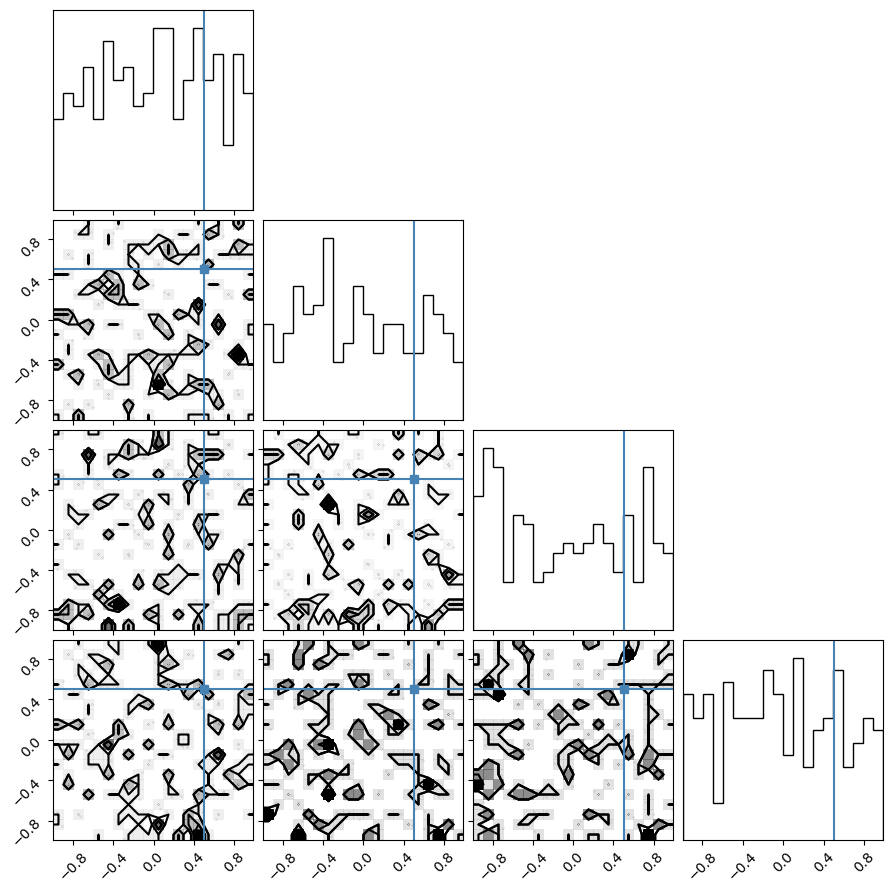

 20%|██        | 20/100 [01:18<01:06,  1.20it/s, loss=33.54, T=1] 

Epoch 20, loss 33.53744530666223


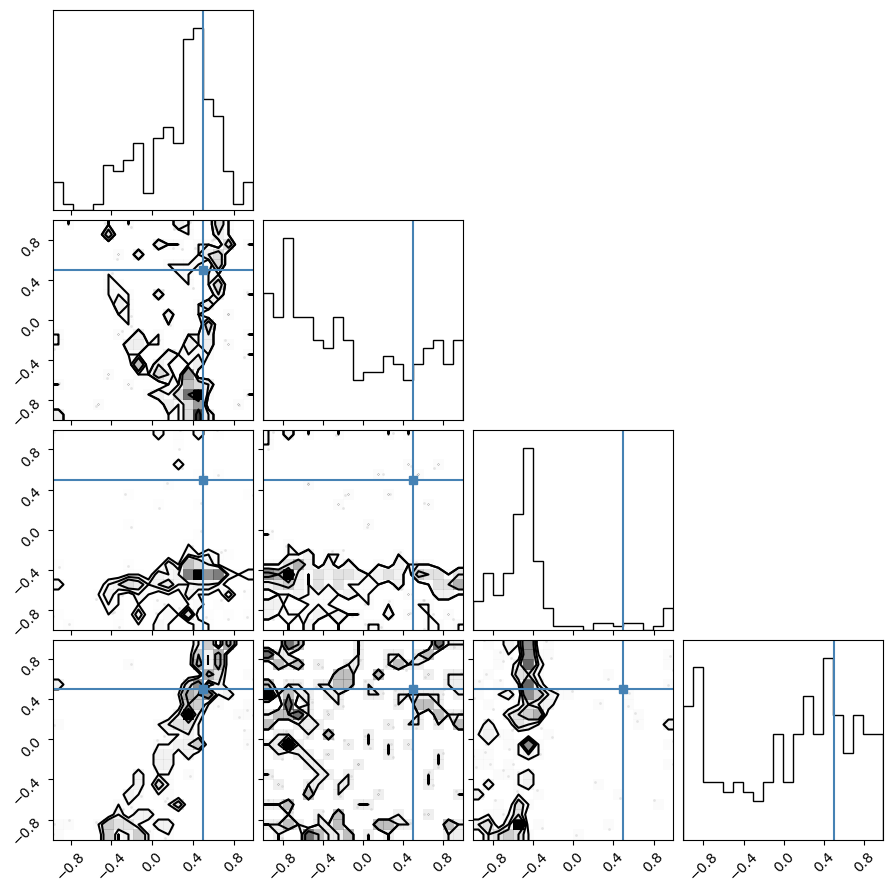

 40%|████      | 40/100 [01:35<00:48,  1.24it/s, loss=10.84, T=1]

Epoch 40, loss 10.835089293711633


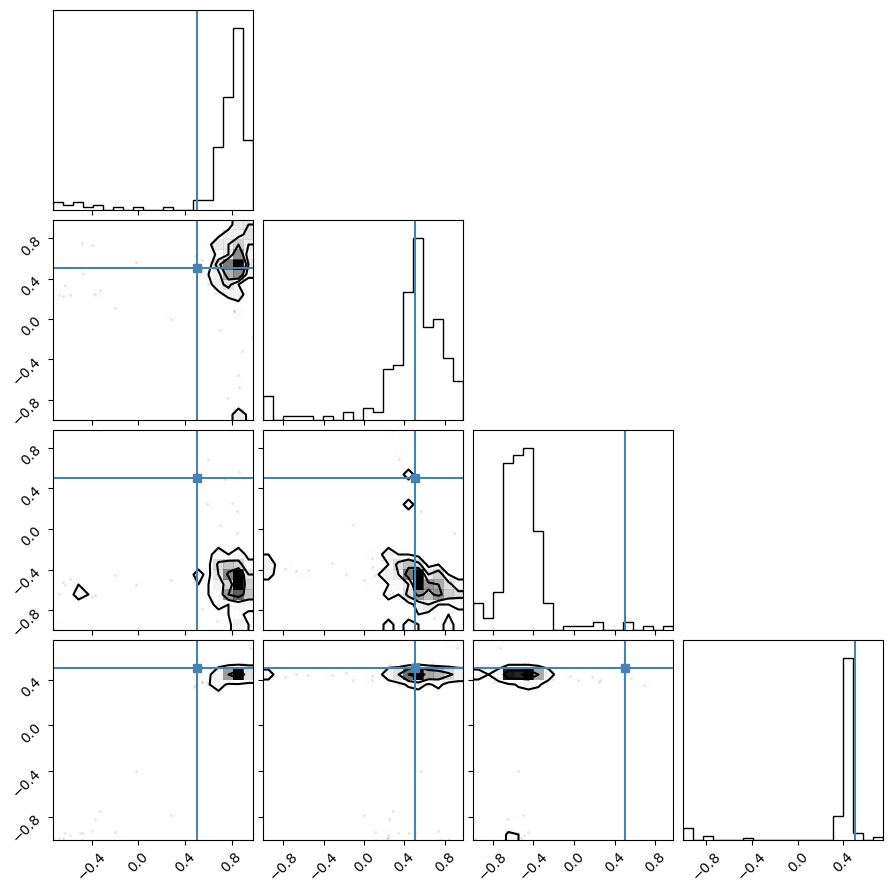

 60%|██████    | 60/100 [01:54<00:34,  1.15it/s, loss=8.68, T=1] 

Epoch 60, loss 8.678618650059148


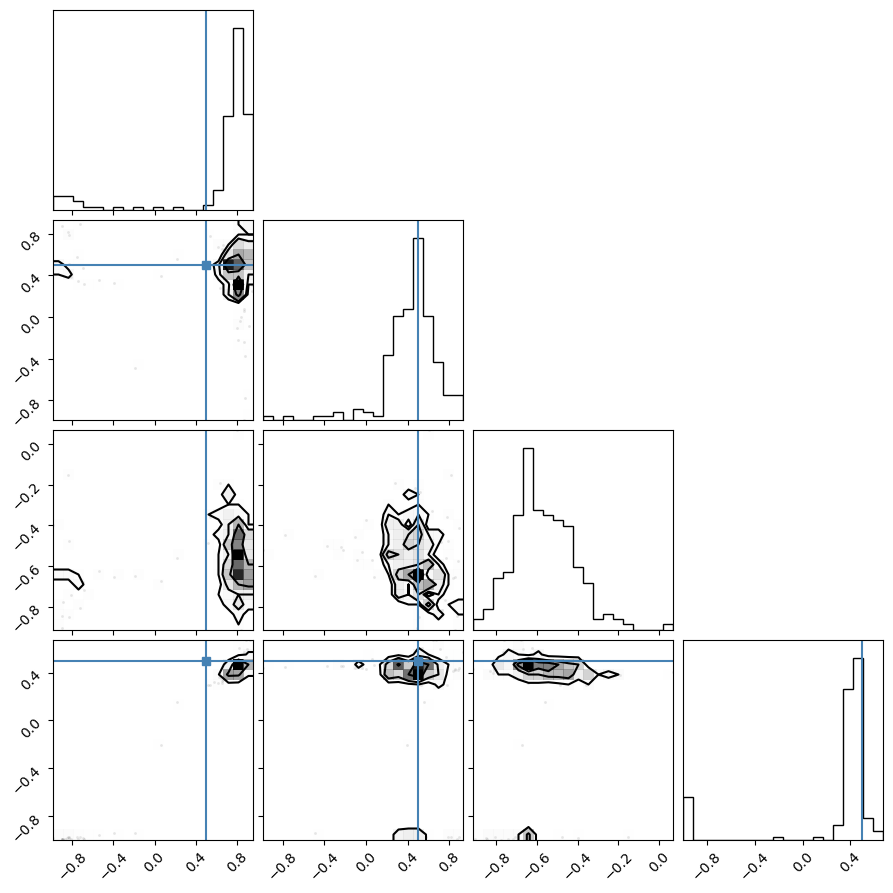

 80%|████████  | 80/100 [02:12<00:16,  1.19it/s, loss=6.08, T=1]

Epoch 80, loss 6.081597799527346


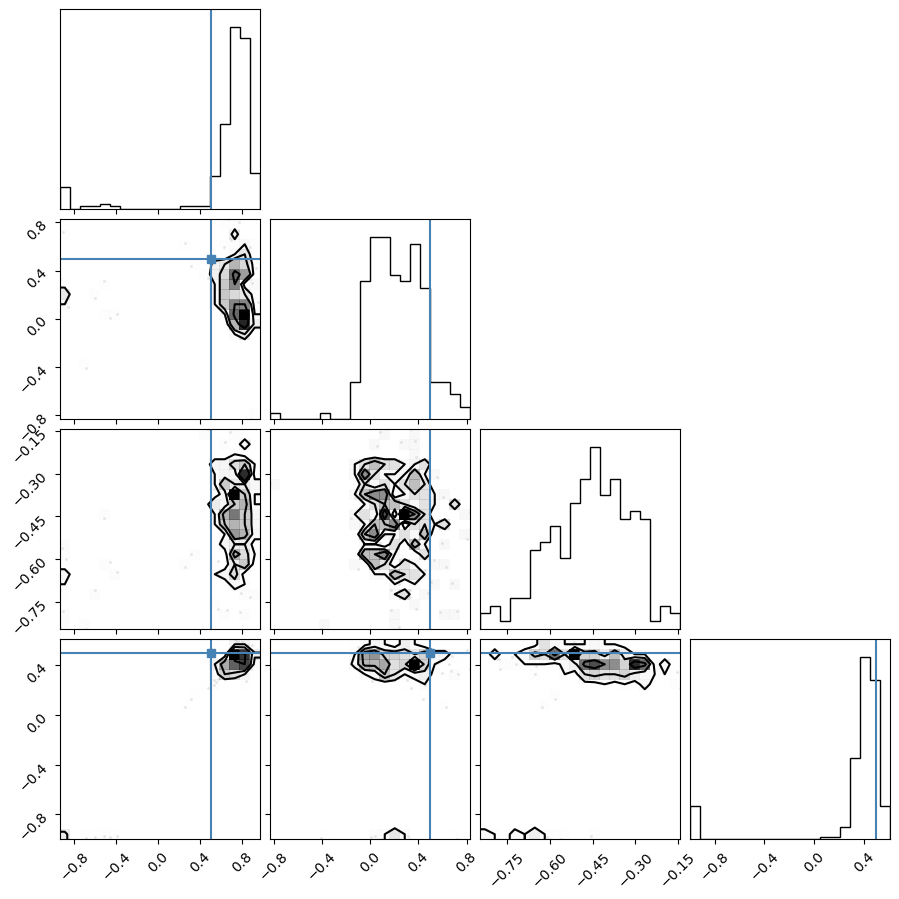

100%|██████████| 100/100 [02:31<00:00,  1.51s/it, loss=6.18, T=1]


Done!


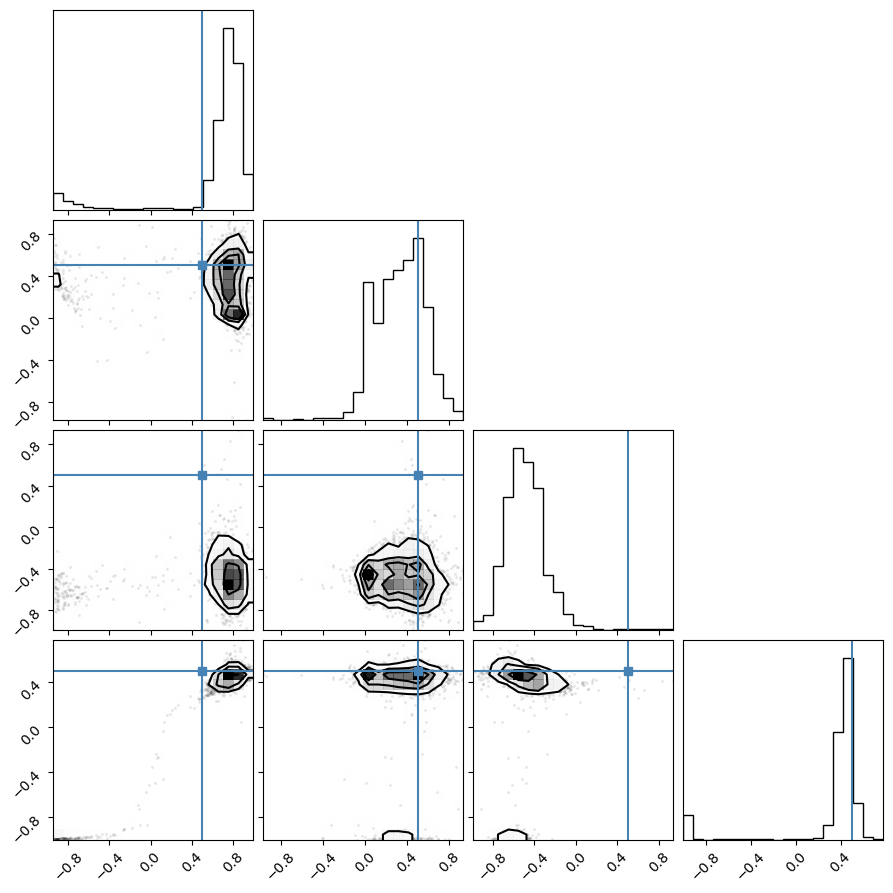

In [20]:

n_params = 4
flow_num_layers = 4
hidden_size = 16
mlp_num_layers = 2
num_bins = 4


# perform variational inference
epochs = 100
loss = dict(train=[], val=[])
Nsamps = 20

learning_rate = 0.01
optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

prng_seq = hk.PRNGSequence(42)
key = next(prng_seq)
params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
opt_state = optimiser.init(params)

from tqdm import tqdm, trange
   
ldict = dict(loss = 0, T=1)

log_l = LogL()         

with trange(epochs) as tepochs:
    for epoch in tepochs:
  
        #update NN params (stochastic gradient descent with Adam optimiser)
        prng_key = next(prng_seq)
        loss = loss_fn(params,  prng_key, Nsamps)
        ldict['loss'] = f'{loss:.2f}'
        tepochs.set_postfix(ldict, refresh=True)
        params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)
            
            
        #print results every 50 iterations
        if epoch%20 == 0:
            print(f'Epoch {epoch}, loss {loss}')
            x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
            x_gen = np.array(x_gen, copy=False)
            p_gen = np.vstack(list(log_l.array_to_phys_m(x_gen).values()))
            truths = [0.5,0.5,0.5,0.5]
            fig = corner.corner(p_gen.T, truths = truths)
            plt.show()

print("Done!")

x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys_m(x_gen).values()))
truths = [0.5,0.5,0.5,0.5]
fig = corner.corner(p_gen.T, truths = truths)
plt.show()

In [113]:
theta

[10.0, 9, 1, 2.0]

In [ ]:
truths

In [ ]:
x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)

In [ ]:
x_gen[:2,:]
logL([ 0.17288971, -0.6864164 , -0.78445077, -0.62187004])

In [ ]:
x_gen[:2,:]

In [ ]:
logL(x_gen[:1][0])

In [ ]:
x_gen[:1][0]

In [ ]:
x_gen[:1]

In [ ]:
[logL(theta) for theta in x_gen[]

In [ ]:
logL

In [ ]:
import jimgw
from jimgw.PE.detector_projection import make_detector_response
from jimgw.PE.detector_projection import make_antenna_response
from jimgw.PE.detector_preset import * 

In [ ]:
import lal


In [ ]:
H1_response = make_detector_response(H1.laldetector.response, H1.laldetector.location)   #detector_response(f, hp, hc, ra, dec, gmst, psi), strain in freq domain
gps = lal.LIGOTimeGPS(t0)
gmst_rad = lal.GreenwichMeanSiderealTime(gps)
antenna_response_plus = make_antenna_response(H1.laldetector.response, 'plus')
antenna_response_plus(ra, dec, gmst_rad, psi)

In [ ]:
fp, fc = H1.get_antenna_response_jax(ra, dec, psi, t0)


